#  Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam


# Load Dataset

In [2]:
df = pd.read_csv("card_transdata.csv")
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


# EDA (Exploratory Data Analysis)

## Correlation Heatmap

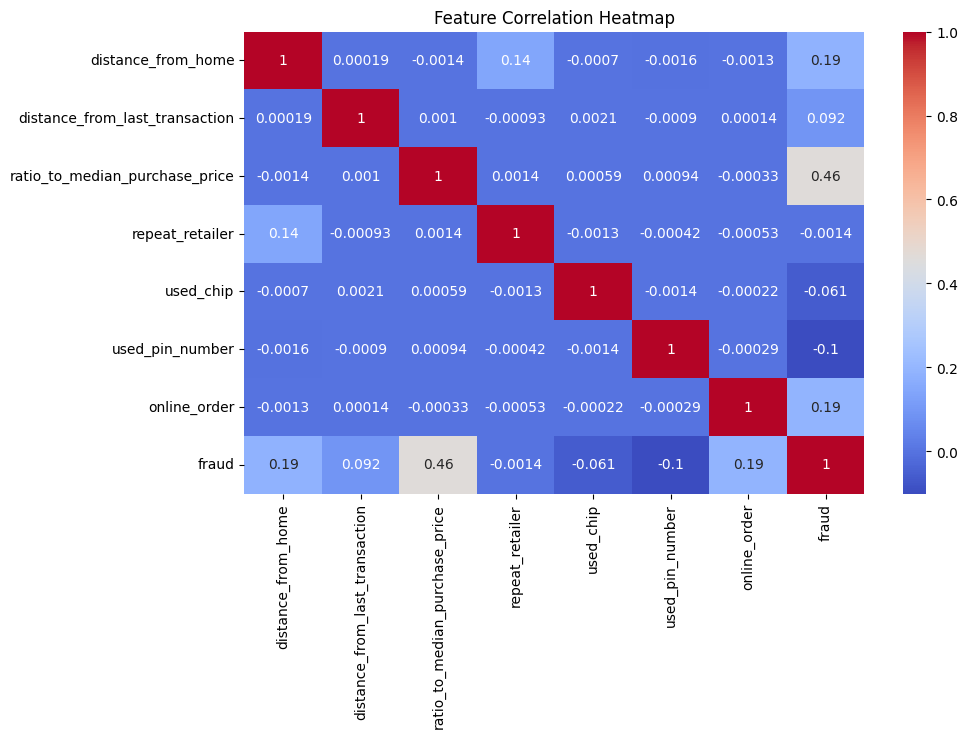

In [3]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

## Feature Distribution

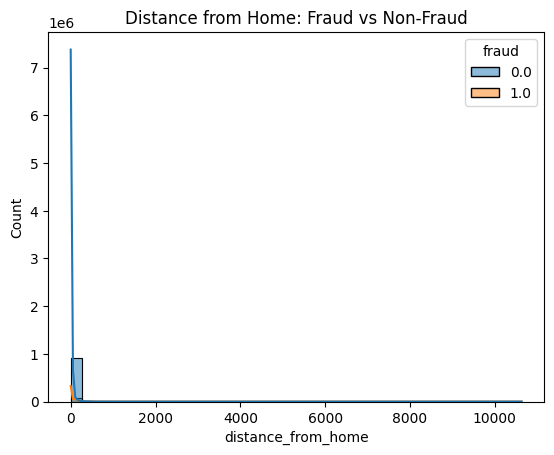

In [4]:
sns.histplot(data=df, x='distance_from_home', hue='fraud', kde=True, bins=40)
plt.title('Distance from Home: Fraud vs Non-Fraud')
plt.show()


## Count Plots

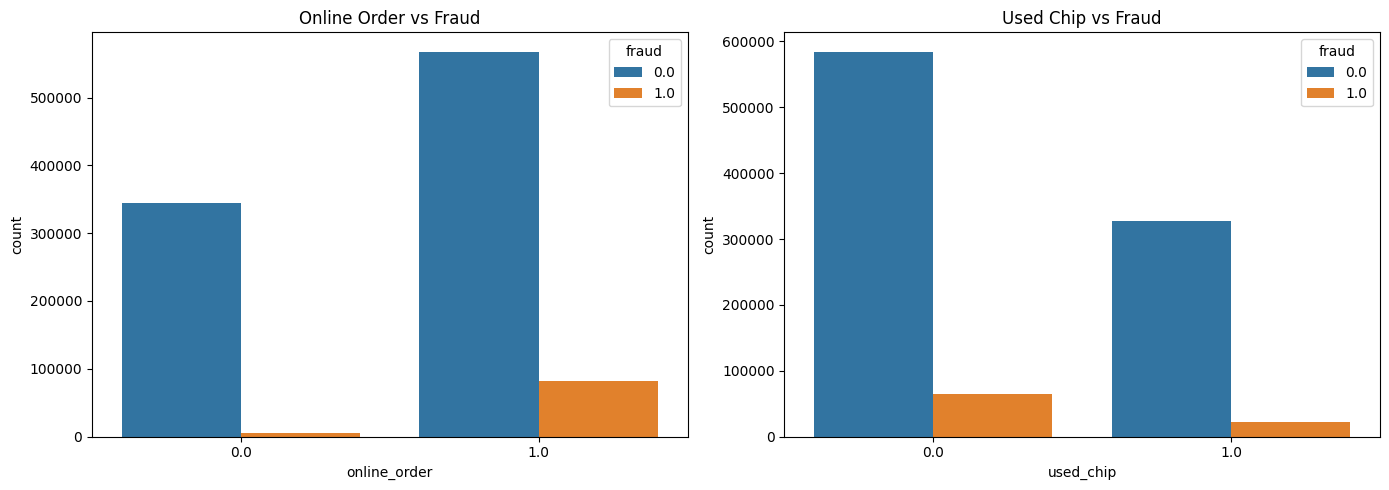

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.countplot(ax=axes[0], x='online_order', hue='fraud', data=df)
axes[0].set_title('Online Order vs Fraud')
sns.countplot(ax=axes[1], x='used_chip', hue='fraud', data=df)
axes[1].set_title('Used Chip vs Fraud')
plt.tight_layout()
plt.show()

# Preprocessing:

In [6]:
X = df.drop('fraud', axis=1)
y = df['fraud']

## Scaling

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## SMOTE

In [8]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

## PCA

In [9]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_resampled)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_resampled, test_size=0.3, random_state=42)

# Train Supervised Models

## Logistic Regression

In [11]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
log_preds = log_model.predict(X_test)

## Random Forest


In [12]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

## XGBoost

In [13]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:33:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# Evaluation Function


Logistic Regression Results
[[250869  23078]
 [ 20887 252725]]
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92    273947
         1.0       0.92      0.92      0.92    273612

    accuracy                           0.92    547559
   macro avg       0.92      0.92      0.92    547559
weighted avg       0.92      0.92      0.92    547559

AUC Score: 0.9197097007108184

Random Forest Results
[[273584    363]
 [    20 273592]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    273947
         1.0       1.00      1.00      1.00    273612

    accuracy                           1.00    547559
   macro avg       1.00      1.00      1.00    547559
weighted avg       1.00      1.00      1.00    547559

AUC Score: 0.99930091498131

XGBoost Results
[[273058    889]
 [    64 273548]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    273947
     

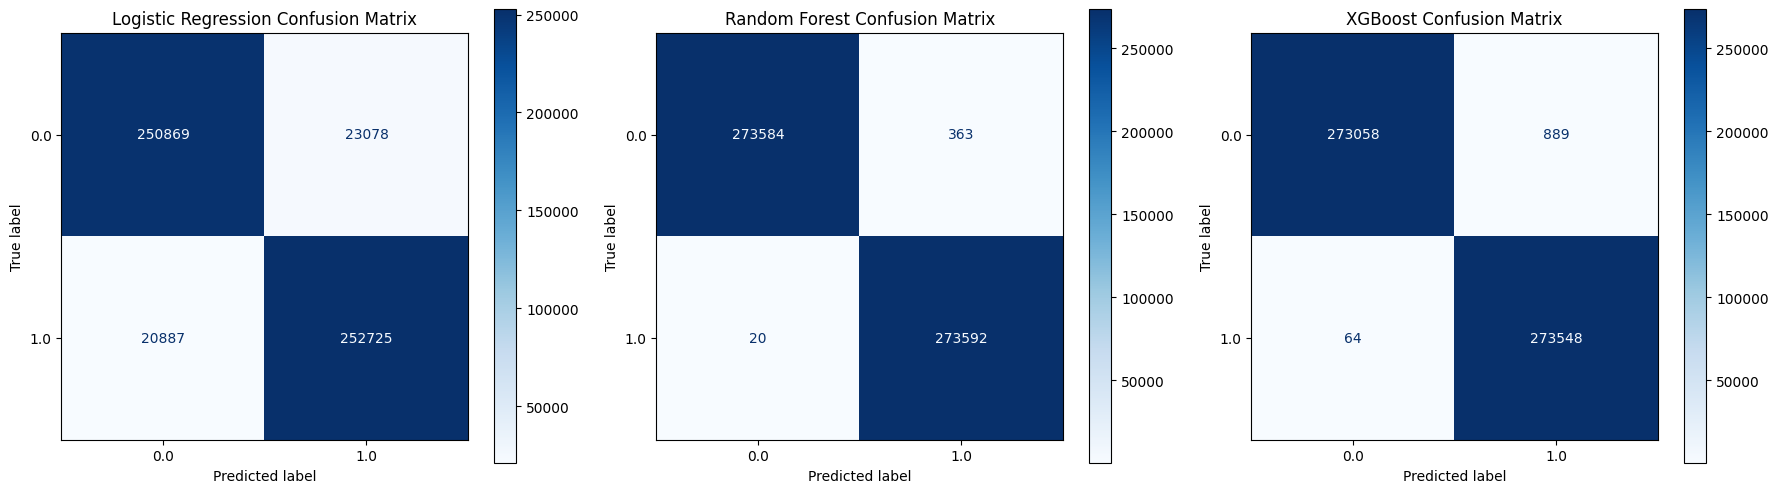

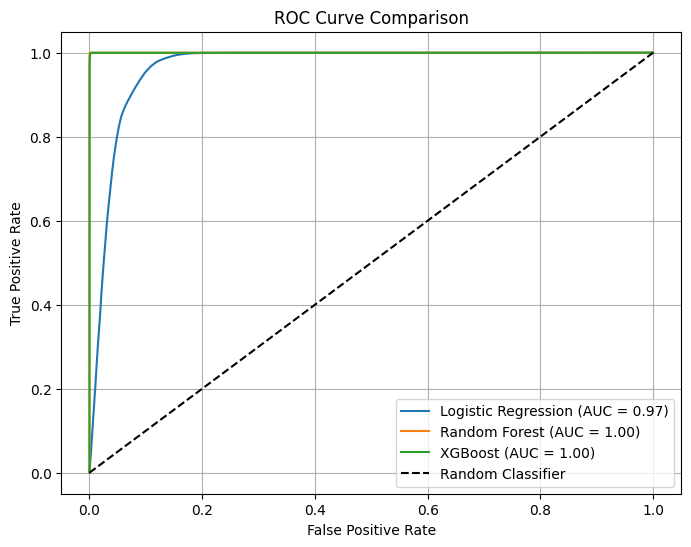

In [26]:
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# Simplified evaluation function: print metrics + confusion matrix
def evaluate_model(name, y_true, y_pred, ax_cm=None):
    print(f"\n{name} Results")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    auc = roc_auc_score(y_true, y_pred)
    print("AUC Score:", auc)

    # Confusion matrix plotting
    if ax_cm:
        ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax_cm, cmap='Blues')
        ax_cm.set_title(f'{name} Confusion Matrix')

# Generate probabilities for ROC curve
log_probs = log_model.predict_proba(X_test)[:, 1]
rf_probs = rf_model.predict_proba(X_test)[:, 1]
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

# ----------------------------
# 1. CONFUSION MATRIX PLOTS
# ----------------------------
fig_cm, axes_cm = plt.subplots(1, 3, figsize=(18, 5))

evaluate_model("Logistic Regression", y_test, log_preds, ax_cm=axes_cm[0])
evaluate_model("Random Forest", y_test, rf_preds, ax_cm=axes_cm[1])
evaluate_model("XGBoost", y_test, xgb_preds, ax_cm=axes_cm[2])

plt.tight_layout()
plt.show()

# ----------------------------
# 2. ROC CURVE COMPARISON PLOT
# ----------------------------
fpr_log, tpr_log, _ = roc_curve(y_test, log_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)

auc_log = roc_auc_score(y_test, log_probs)
auc_rf = roc_auc_score(y_test, rf_probs)
auc_xgb = roc_auc_score(y_test, xgb_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {auc_log:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid()
plt.show()


# Unsupervised Models

## Isolation Forest

In [15]:
iso = IsolationForest(contamination=0.05)
unsupervised_preds = iso.fit_predict(X_scaled)
unsupervised_preds = np.where(unsupervised_preds == -1, 1, 0)
print("Isolation Forest Accuracy:", accuracy_score(y, unsupervised_preds))


Isolation Forest Accuracy: 0.886287


## Autoencoder

In [16]:
X_normal = X_scaled[y == 0]
input_dim = X_scaled.shape[1]
encoding_dim = 5

# Build Autoencoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)
autoencoder = Model(inputs=input_layer, outputs=decoded)

autoencoder.compile(optimizer=Adam(0.001), loss='mse')
autoencoder.fit(X_normal, X_normal, epochs=10, batch_size=32, shuffle=True, verbose=1)

# Reconstruction error
reconstructions = autoencoder.predict(X_scaled)
mse = np.mean(np.square(X_scaled - reconstructions), axis=1)
threshold = np.percentile(mse[y == 0], 95)
autoencoder_preds = (mse > threshold).astype(int)

print("Autoencoder Accuracy:", accuracy_score(y, autoencoder_preds))
print("Autoencoder AUC:", roc_auc_score(y, autoencoder_preds))


Epoch 1/10
28519/28519 ━━━━━━━━━━━━━━━━━━━━ 60s 2ms/step - loss: 0.6640
Epoch 2/10
28519/28519 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - loss: 0.5639
Epoch 3/10
28519/28519 ━━━━━━━━━━━━━━━━━━━━ 81s 2ms/step - loss: 0.5755
Epoch 4/10
28519/28519 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - loss: 0.5475
Epoch 5/10
28519/28519 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - loss: 0.5496
Epoch 6/10
28519/28519 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - loss: 0.5404
Epoch 7/10
28519/28519 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - loss: 0.5509
Epoch 8/10
28519/28519 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - loss: 0.5553
Epoch 9/10
28519/28519 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - loss: 0.6986
Epoch 10/10
28519/28519 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - loss: 0.5826
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 38s 1ms/step
Autoencoder Accuracy: 0.882508
Autoencoder AUC: 0.5639041888374008


In [19]:
results_df = pd.DataFrame()
results_df['Actual_Fraud'] = y.reset_index(drop=True)

# Add predictions from all models
results_df['Logistic_Pred'] = pd.Series(log_preds)
results_df['RandomForest_Pred'] = pd.Series(rf_preds)
results_df['XGBoost_Pred'] = pd.Series(xgb_preds)

# Add unsupervised model predictions (full dataset)
results_df['IsolationForest_Pred'] = unsupervised_preds
results_df['Autoencoder_Pred'] = autoencoder_preds

# Show the first 10 rows
results_df.head(10)



,Actual_Fraud,Logistic_Pred,RandomForest_Pred,XGBoost_Pred,IsolationForest_Pred,Autoencoder_Pred
0,0.0,1.0,1.0,1.0,0,0
1,0.0,0.0,0.0,0.0,0,0
2,0.0,1.0,1.0,1.0,0,0
3,0.0,0.0,0.0,0.0,0,0
4,0.0,0.0,0.0,0.0,0,0
5,0.0,1.0,1.0,1.0,0,0
6,0.0,1.0,1.0,1.0,0,0
7,0.0,0.0,0.0,0.0,0,0
8,0.0,1.0,1.0,1.0,0,1
9,0.0,0.0,0.0,0.0,0,0
